# 1. Import needed libraries

In [1]:
import os
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
#---------------------------------------
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
#---------------------------------------
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import keras
#---------------------------------------

# 2. Preprocessing

## 2.1 Load data

In [2]:
def train_df(tr_path):
    classes, class_paths = zip(*[(label, os.path.join(tr_path, label, image))
                                 for label in os.listdir(tr_path) if os.path.isdir(os.path.join(tr_path, label))
                                 for image in os.listdir(os.path.join(tr_path, label))])

    tr_df = pd.DataFrame({'Class Path': class_paths, 'Class': classes})
    return tr_df

In [3]:
def test_df(ts_path):
    classes, class_paths = zip(*[(label, os.path.join(ts_path, label, image))
                                 for label in os.listdir(ts_path) if os.path.isdir(os.path.join(ts_path, label))
                                 for image in os.listdir(os.path.join(ts_path, label))])

    ts_df = pd.DataFrame({'Class Path': class_paths, 'Class': classes})
    return ts_df

In [4]:
tr_df = train_df('archive/Training')

In [5]:
tr_df

,Class Path,Class
0,archive/Training\glioma\Tr-glTr_0000.jpg,glioma
1,archive/Training\glioma\Tr-glTr_0001.jpg,glioma
2,archive/Training\glioma\Tr-glTr_0002.jpg,glioma
3,archive/Training\glioma\Tr-glTr_0003.jpg,glioma
4,archive/Training\glioma\Tr-glTr_0004.jpg,glioma
...,...,...
5707,archive/Training\pituitary\Tr-pi_1452.jpg,pituitary
5708,archive/Training\pituitary\Tr-pi_1453.jpg,pituitary
5709,archive/Training\pituitary\Tr-pi_1454.jpg,pituitary
5710,archive/Training\pituitary\Tr-pi_1455.jpg,pituitary


In [6]:
ts_df = test_df('archive/Testing')

In [7]:
ts_df

,Class Path,Class
0,archive/Testing\glioma\Te-glTr_0000.jpg,glioma
1,archive/Testing\glioma\Te-glTr_0001.jpg,glioma
2,archive/Testing\glioma\Te-glTr_0002.jpg,glioma
3,archive/Testing\glioma\Te-glTr_0003.jpg,glioma
4,archive/Testing\glioma\Te-glTr_0004.jpg,glioma
...,...,...
1306,archive/Testing\pituitary\Te-pi_0295.jpg,pituitary
1307,archive/Testing\pituitary\Te-pi_0296.jpg,pituitary
1308,archive/Testing\pituitary\Te-pi_0297.jpg,pituitary
1309,archive/Testing\pituitary\Te-pi_0298.jpg,pituitary


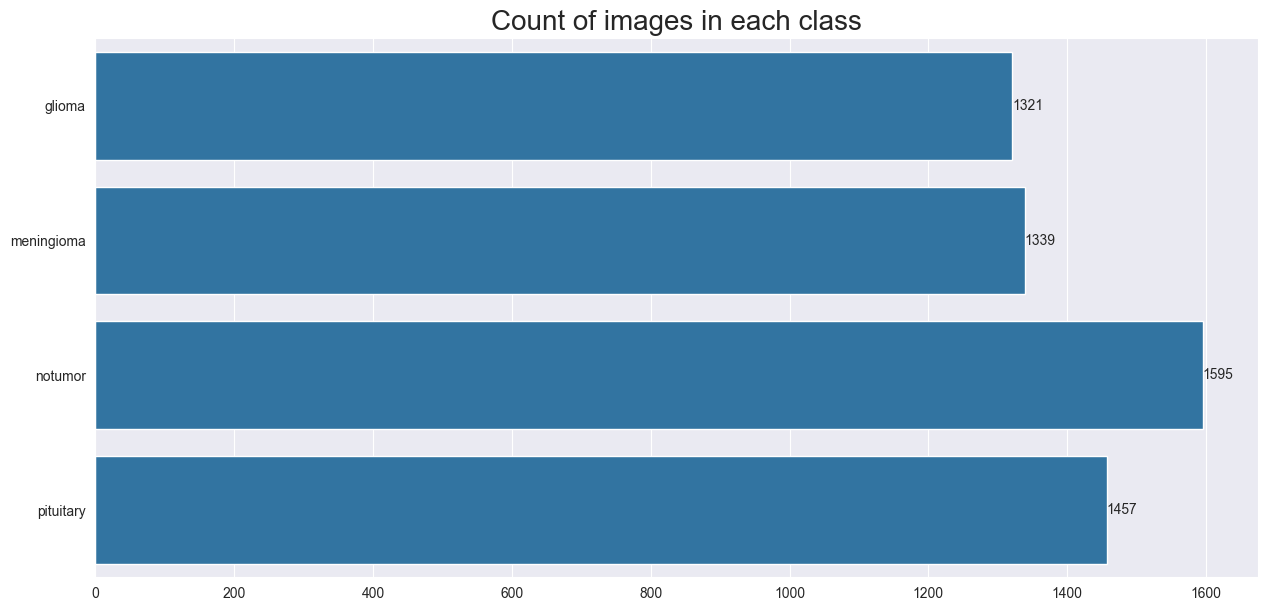

In [8]:
# Count of images in each class in train data
plt.figure(figsize=(15,7))
ax = sns.countplot(data=tr_df , y=tr_df['Class'])

plt.xlabel('')
plt.ylabel('')
plt.title('Count of images in each class', fontsize=20)
ax.bar_label(ax.containers[0])
plt.show()

C:\Users\saish\AppData\Local\Temp\ipykernel_9164\3564058071.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(y=ts_df['Class'], palette='viridis')


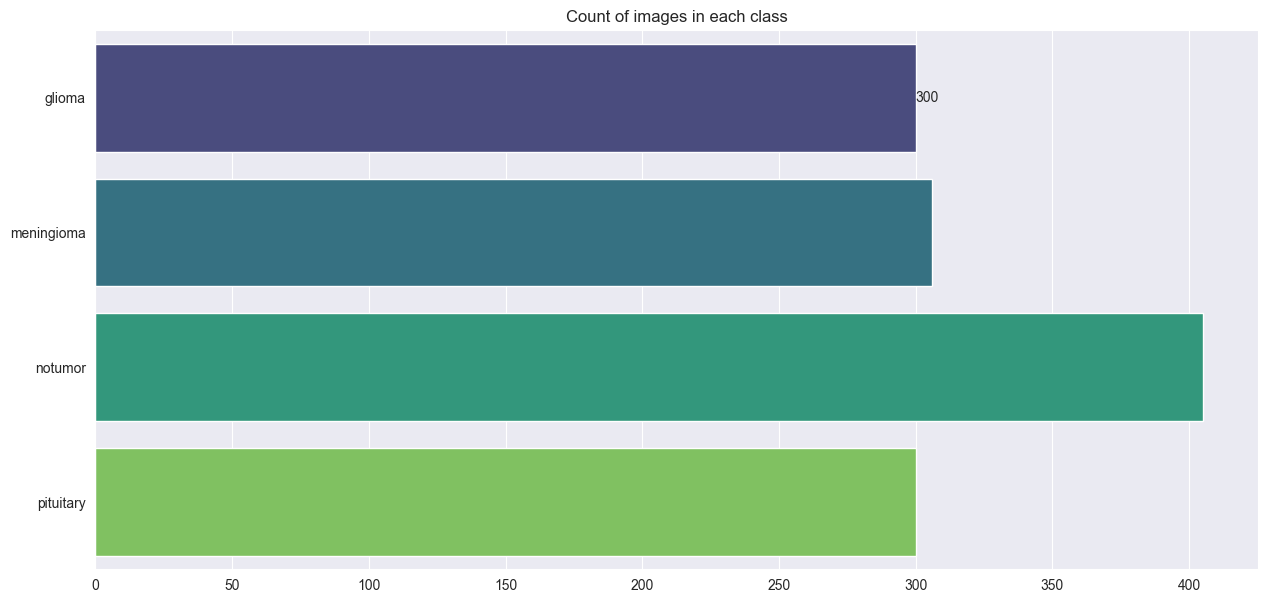

In [9]:
#Count each class in test data
plt.figure(figsize=(15, 7))
ax = sns.countplot(y=ts_df['Class'], palette='viridis')

ax.set(xlabel='', ylabel='', title='Count of images in each class')
ax.bar_label(ax.containers[0])

plt.show()

## 2.2 Split data into train, test, valid

In [10]:
valid_df, ts_df = train_test_split(ts_df, train_size=0.8, random_state=42, stratify=ts_df['Class'])

In [11]:
valid_df

,Class Path,Class
1117,archive/Testing\pituitary\Te-pi_0106.jpg,pituitary
941,archive/Testing\notumor\Te-no_0335.jpg,notumor
674,archive/Testing\notumor\Te-no_0068.jpg,notumor
1199,archive/Testing\pituitary\Te-pi_0188.jpg,pituitary
819,archive/Testing\notumor\Te-no_0213.jpg,notumor
...,...,...
127,archive/Testing\glioma\Te-gl_0127.jpg,glioma
109,archive/Testing\glioma\Te-gl_0109.jpg,glioma
658,archive/Testing\notumor\Te-no_0052.jpg,notumor
650,archive/Testing\notumor\Te-no_0044.jpg,notumor


## 2.3 Data preprocessing

In [12]:
batch_size = 100
img_size = (150, 150)

_gen = ImageDataGenerator(rescale=1/255,
                          brightness_range=(0.8, 1.2))

ts_gen = ImageDataGenerator(rescale=1/255)


tr_gen = _gen.flow_from_dataframe(tr_df, x_col='Class Path',
                                  y_col='Class', batch_size=batch_size,
                                  target_size=img_size)

valid_gen = _gen.flow_from_dataframe(valid_df, x_col='Class Path',
                                     y_col='Class', batch_size=batch_size,
                                     target_size=img_size)

ts_gen = ts_gen.flow_from_dataframe(ts_df, x_col='Class Path',
                                  y_col='Class', batch_size=16,
                                  target_size=img_size, shuffle=False)

Found 5712 validated image filenames belonging to 4 classes.
Found 1048 validated image filenames belonging to 4 classes.
Found 263 validated image filenames belonging to 4 classes.


## 2.4 Getting samples from data

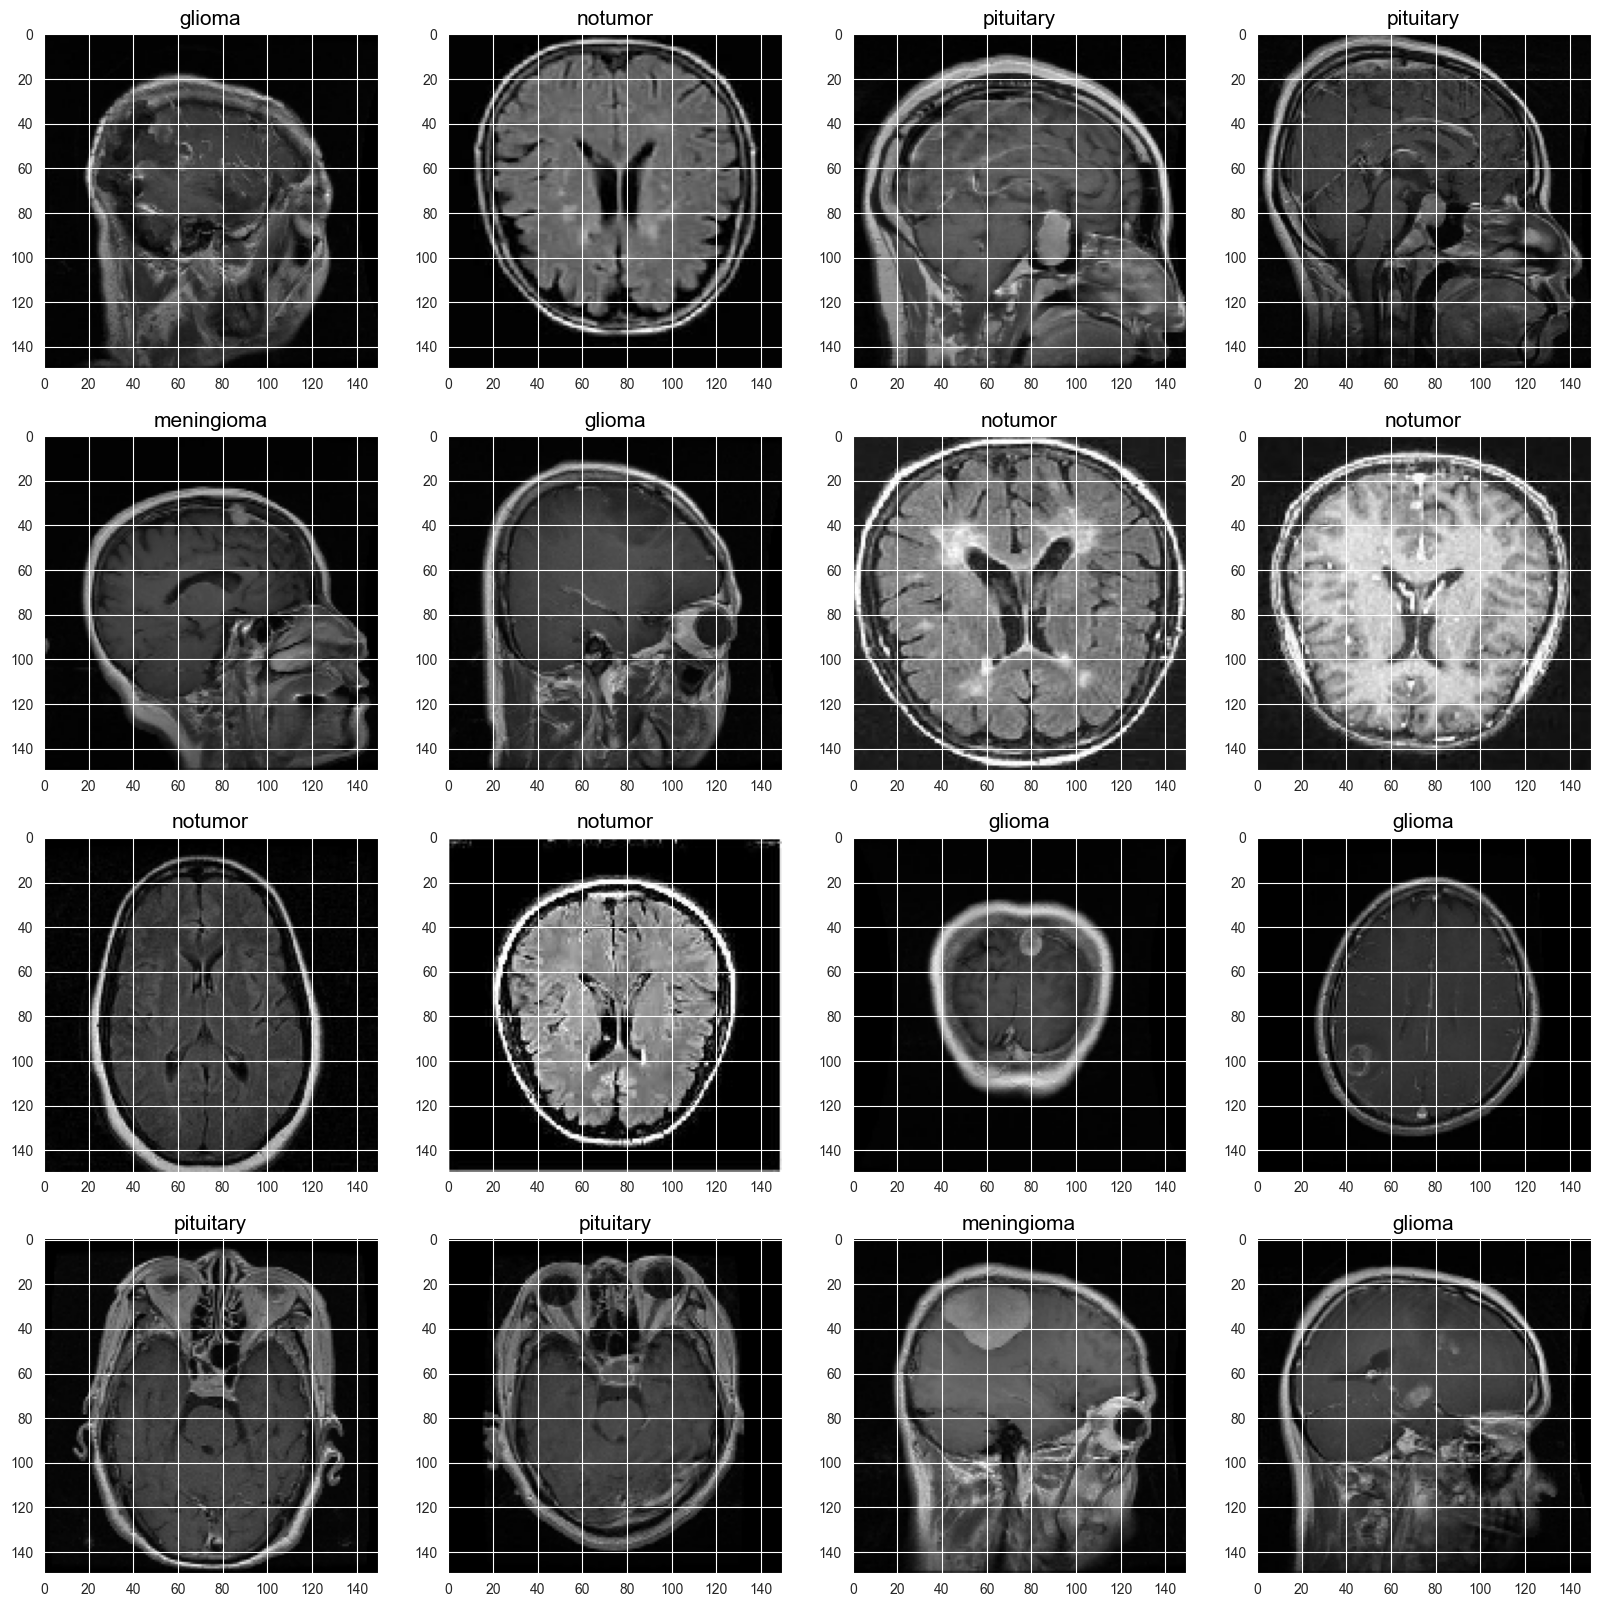

In [13]:
class_dict = tr_gen.class_indices
classes = list(class_dict.keys())
images, labels = next(ts_gen)

plt.figure(figsize=(20, 20))

for i, (image, label) in enumerate(zip(images, labels)):
    plt.subplot(4,4, i + 1)
    plt.imshow(image)
    class_name = classes[np.argmax(label)]
    plt.title(class_name, color='k', fontsize=15)

plt.show()

# 3. Building Deep Learning Model

In [14]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization

# Define the CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(256, activation='relu'),
    BatchNormalization(axis=1),
    Dropout(0.5),
    Dense(4, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', Precision(), Recall()])

# Define early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, mode ="auto")

model.summary()

# Train the model
# history = model.fit(tr_gen, epochs=50, validation_data=valid_gen, callbacks=[early_stopping])
# # Save the model
# model.save("brain_tumor_detection_model.keras") 

C:\S\programming\AI\pythonProject1\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 15, 15, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     1,605,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,848,772 (7.05 MB)

 Trainable params: 1,848,260 (7.05 MB)

 Non-trainable params: 512 (2.00 KB)

In [ ]:
history = model.fit(tr_gen, epochs=50, validation_data=valid_gen, callbacks=[early_stopping])
# Save the model
model.save("brain_tumor_classification_model.keras") 

Epoch 1/50


C:\S\programming\AI\pythonProject1\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


58/58 ━━━━━━━━━━━━━━━━━━━━ 217s 3s/step - accuracy: 0.6606 - loss: 0.8554 - precision: 0.7205 - recall: 0.5710 - val_accuracy: 0.4666 - val_loss: 1.1738 - val_precision: 0.6906 - val_recall: 0.3302
Epoch 2/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 113s 2s/step - accuracy: 0.8362 - loss: 0.4742 - precision: 0.8578 - recall: 0.8012 - val_accuracy: 0.5658 - val_loss: 0.9757 - val_precision: 0.8525 - val_recall: 0.3531
Epoch 3/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 71s 1s/step - accuracy: 0.8812 - loss: 0.3368 - precision: 0.8997 - recall: 0.8621 - val_accuracy: 0.8406 - val_loss: 0.7039 - val_precision: 0.9249 - val_recall: 0.5172
Epoch 4/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 74s 1s/step - accuracy: 0.9188 - loss: 0.2202 - precision: 0.9271 - recall: 0.9075 - val_accuracy: 0.7452 - val_loss: 0.6671 - val_precision: 0.8362 - val_recall: 0.6135
Epoch 5/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 74s 1s/step - accuracy: 0.9384 - loss: 0.1834 - precision: 0.9479 - recall: 0.9315 - val_accuracy: 0.8817 - val_loss: 0.3753 - val_precisio

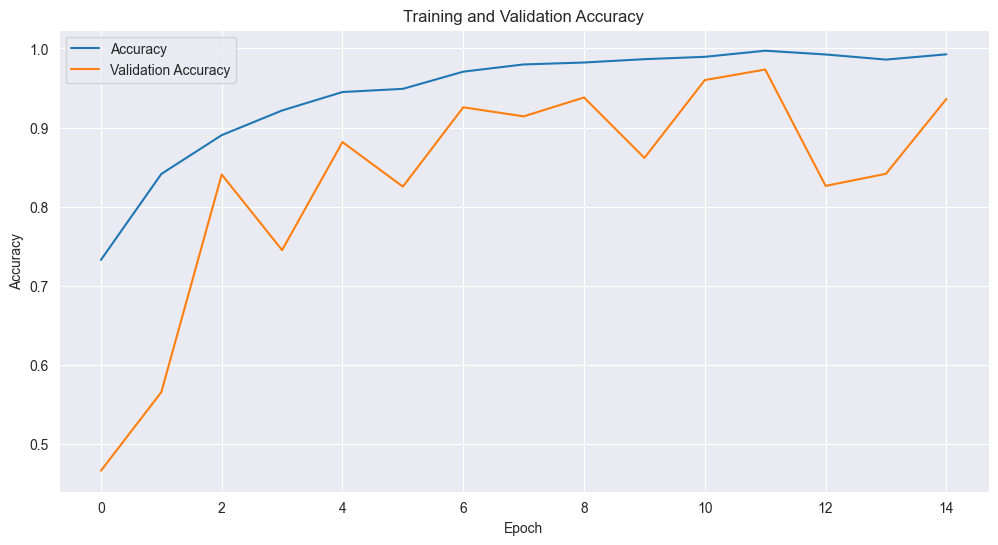

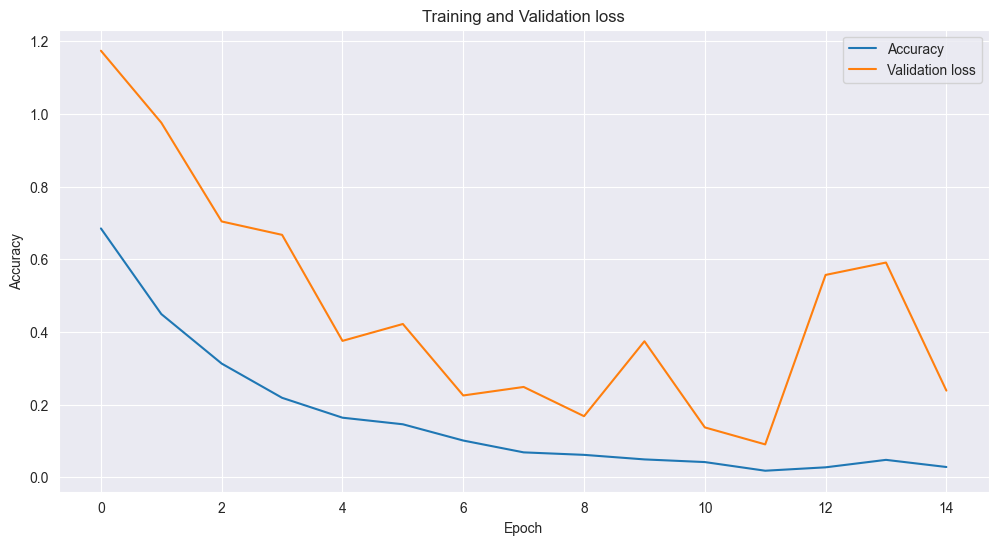

In [16]:
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Accuracy')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [17]:
predictions = model.predict(ts_gen)
predicted_classes = np.argmax(predictions, axis=1)

17/17 ━━━━━━━━━━━━━━━━━━━━ 6s 332ms/step


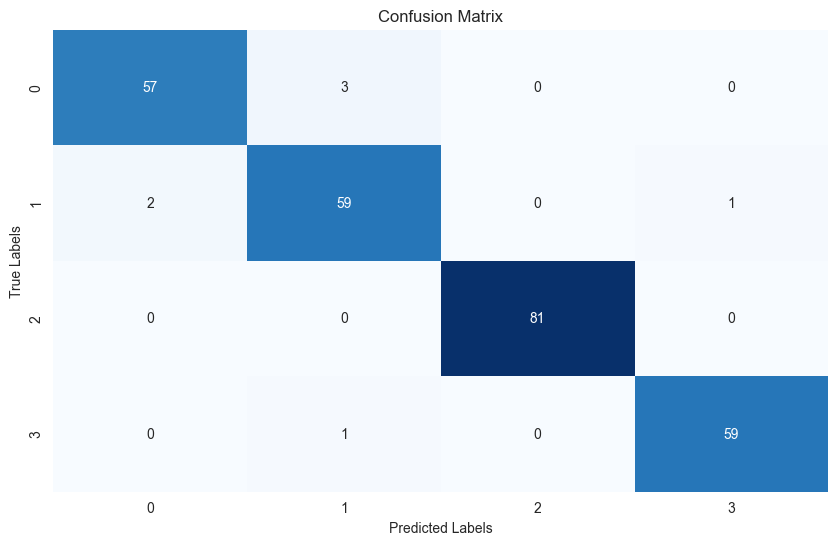

              precision    recall  f1-score   support

      glioma       0.97      0.95      0.96        60
  meningioma       0.94      0.95      0.94        62
     notumor       1.00      1.00      1.00        81
   pituitary       0.98      0.98      0.98        60

    accuracy                           0.97       263
   macro avg       0.97      0.97      0.97       263
weighted avg       0.97      0.97      0.97       263



In [18]:
plt.figure(figsize=(10, 6))
sns.heatmap(confusion_matrix(ts_gen.classes, predicted_classes), annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

print(classification_report(ts_gen.classes, predicted_classes, target_names=classes))


In [19]:
train_score = model.evaluate(tr_gen, verbose=1)
valid_score = model.evaluate(valid_gen, verbose=1)
test_score = model.evaluate(ts_gen, verbose=1)

print(f"Train Loss: {train_score[0]:.4f}")
print(f"Train Accuracy: {train_score[1]*100:.2f}%")
print('-' * 20)
print(f"Validation Loss: {valid_score[0]:.4f}")
print(f"Validation Accuracy: {valid_score[1]*100:.2f}%")
print('-' * 20)
print(f"Test Loss: {test_score[0]:.4f}")
print(f"Test Accuracy: {test_score[1]*100:.2f}%")

58/58 ━━━━━━━━━━━━━━━━━━━━ 28s 476ms/step - accuracy: 0.9997 - loss: 0.0063 - precision: 0.9997 - recall: 0.9997
11/11 ━━━━━━━━━━━━━━━━━━━━ 7s 600ms/step - accuracy: 0.9712 - loss: 0.0810 - precision: 0.9742 - recall: 0.9701
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 0.9692 - loss: 0.0646 - precision: 0.9692 - recall: 0.9692
Train Loss: 0.0063
Train Accuracy: 99.98%
--------------------
Validation Loss: 0.0923
Validation Accuracy: 96.95%
--------------------
Test Loss: 0.0529
Test Accuracy: 97.34%


In [20]:
preds = model.predict(ts_gen)
y_pred = np.argmax(preds, axis=1)

17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step


In [21]:
clr = classification_report(ts_gen.classes, y_pred)
print(clr)

              precision    recall  f1-score   support

           0       0.97      0.95      0.96        60
           1       0.94      0.95      0.94        62
           2       1.00      1.00      1.00        81
           3       0.98      0.98      0.98        60

    accuracy                           0.97       263
   macro avg       0.97      0.97      0.97       263
weighted avg       0.97      0.97      0.97       263



In [22]:
def predict(img_path):
    import numpy as np
    import matplotlib.pyplot as plt
    from PIL import Image
    label = list(class_dict.keys())
    plt.figure(figsize=(12, 12))
    img = Image.open(img_path)
    resized_img = img.resize((150, 150))
    img = np.asarray(resized_img)
    img = np.expand_dims(img, axis=0)
    img = img / 255
    predictions = model.predict(img)
    probs = list(predictions[0])
    labels = label
    plt.subplot(2, 1, 1)
    plt.imshow(resized_img)
    plt.subplot(2, 1, 2)
    bars = plt.barh(labels, probs)
    plt.xlabel('Probability', fontsize=15)
    ax = plt.gca()
    ax.bar_label(bars, fmt = '%.2f')
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


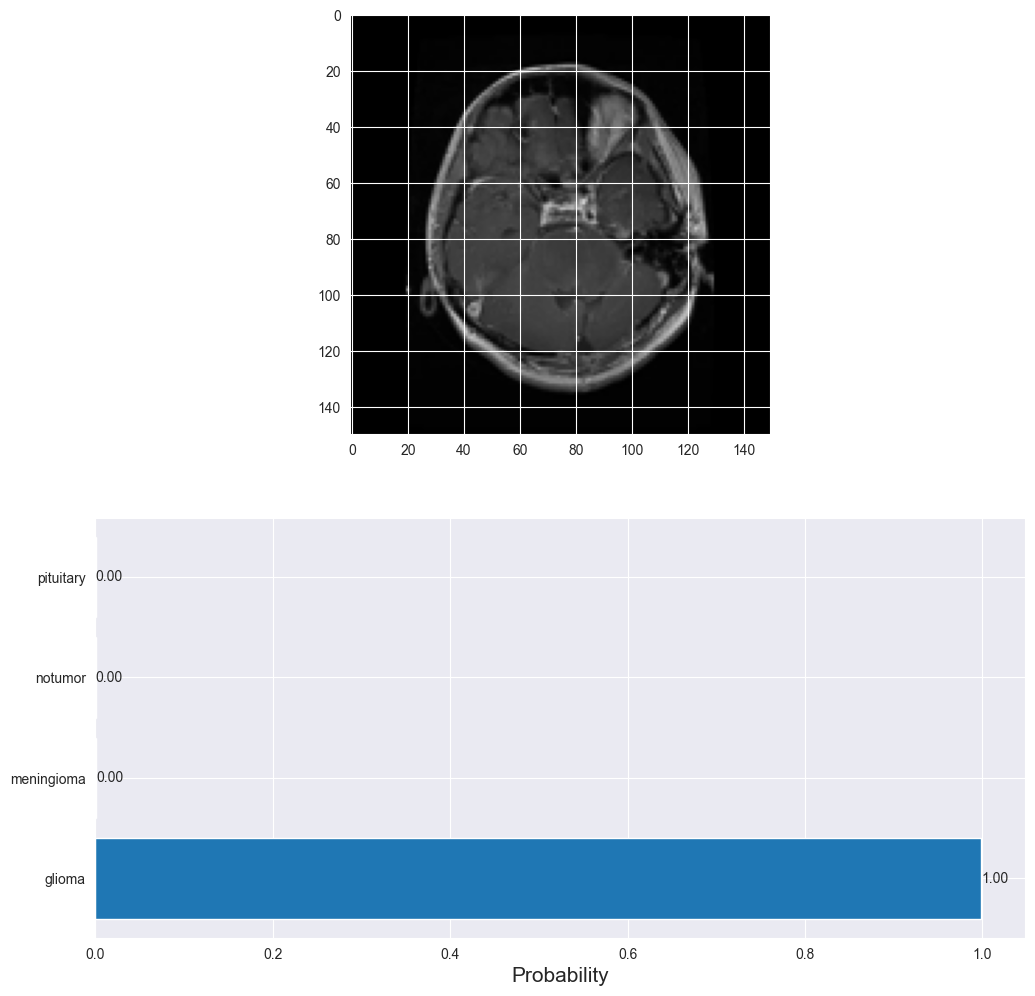

In [24]:
predict("archive/Testing/glioma/Te-gl_0010.jpg")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


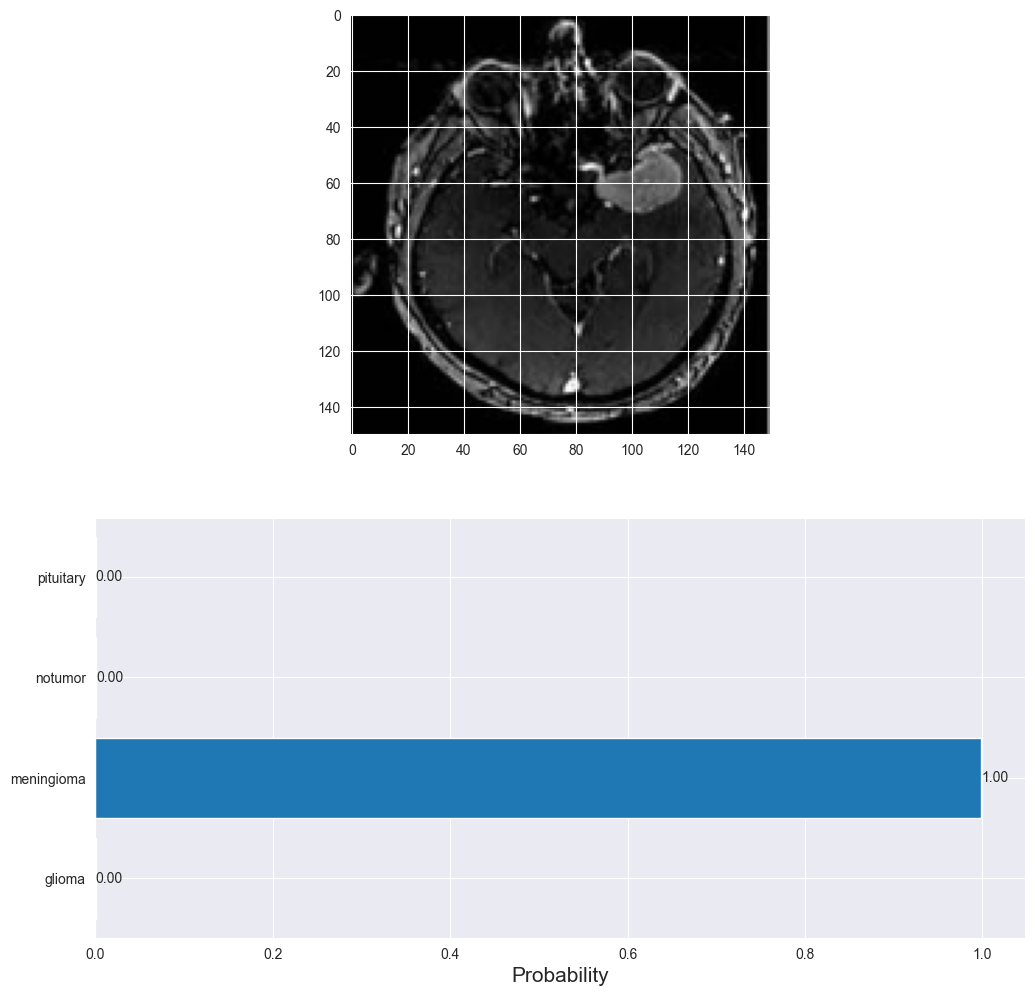

In [25]:
predict("archive/Testing/meningioma/Te-me_0011.jpg")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


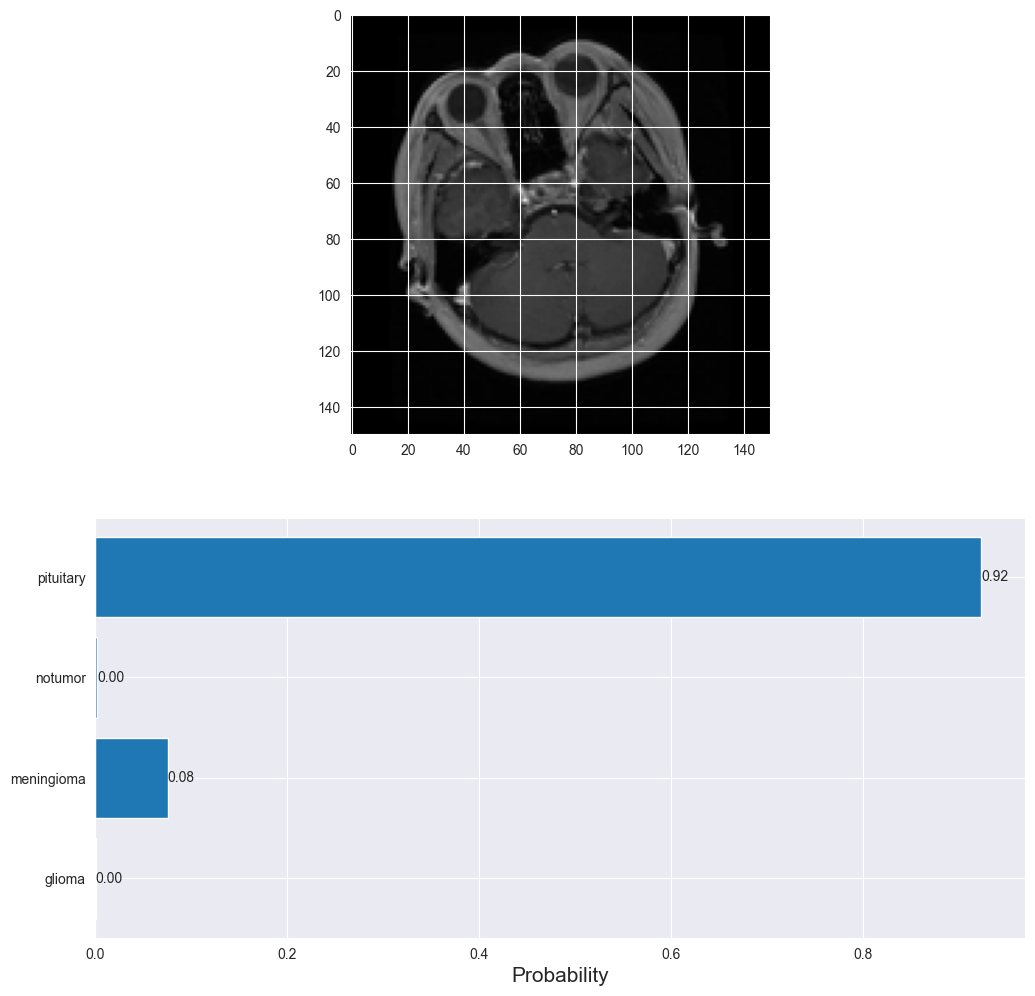

In [26]:
predict("archive/Testing/pituitary/Te-pi_0012.jpg")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


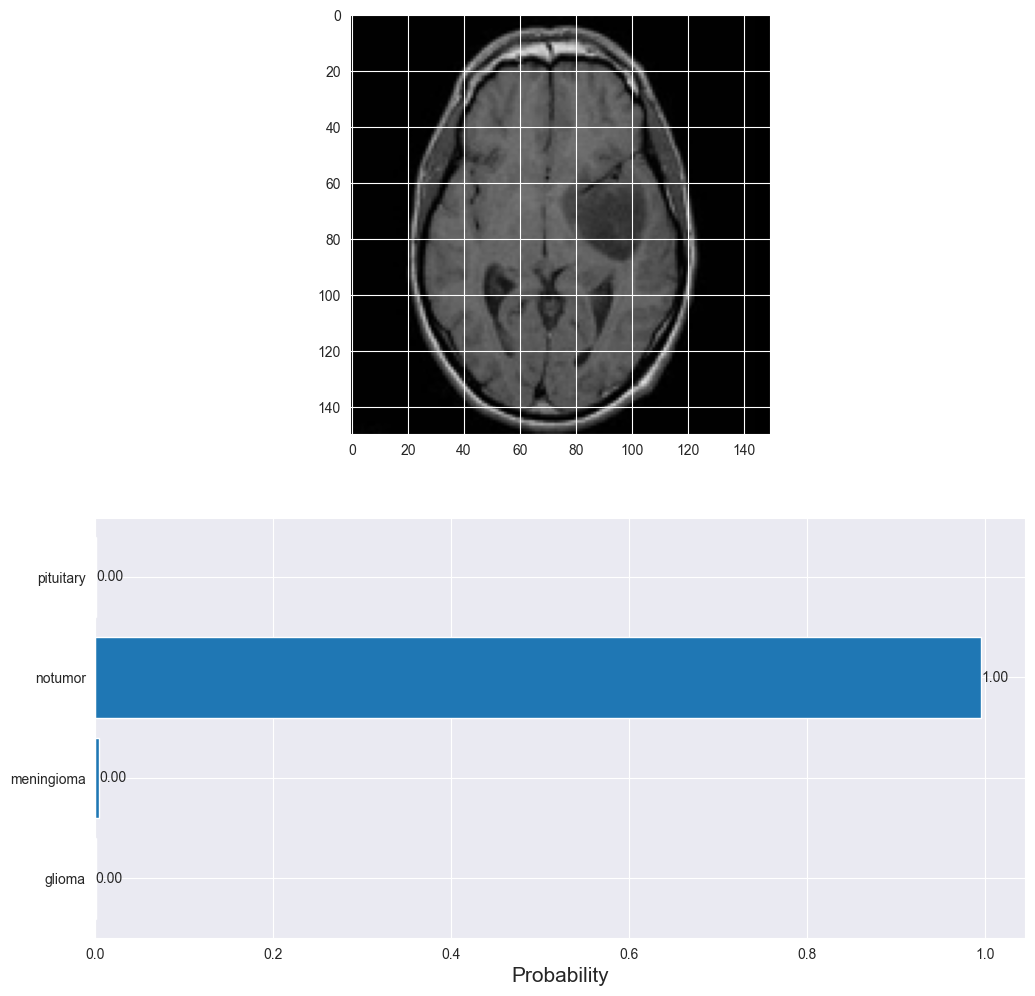

In [27]:
predict("archive/Testing/notumor/Te-no_0033.jpg")